## upload the data

### Connect to Vantage

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import teradataml as tdml
import json
import os
tdml.__version__

'20.00.00.03'

import teradata as tdml
import getpass
Param = {
    'host': '<teradata hostname or ip>',
    'user': '<user>',
    'password': getpass.getpass(),
    'database': '<database par defaut>',
    'temp_database_name': '<user name>',
    'logmech' : '<LDAP ou TDNEGO ou TD2>'
}

tdml.create_context(**Param)

In [2]:
with open('../connections/me.json','r') as f:
    Param = json.load(f)

with open('../connections/csae2.json','r') as f:
    Param = json.load(f)

with open('../connections/csae.json','r') as f:
    Param = json.load(f)

with open('../connections/vantage24.json','r') as f:
    Param_ = json.load(f)

tdml.create_context(**Param)

{'host': 'sto-xo0saiv0ot1sxmj2.env.clearscape.teradata.com', 'user': 'demo_user', 'password': 'demouser', 'database': 'demo_user', 'temp_database_name': 'demo_user'}


Engine(teradatasql://:***@sto-xo0saiv0ot1sxmj2.env.clearscape.teradata.com?DATABASE=demo_user&user=DEMO_USER)

In [3]:
import pandas as pd
import numpy as np

# Define the three types of software problems and corresponding questions
problems_data = {
    "Problem_Type": ["Installation Issue", "Performance Issue", "Functionality Issue"],
    "User_Question": [
        [
            "Why can't I install the software on my machine?",
            "What do I do if the installer keeps crashing?",
            "How do I resolve dependency errors during installation?",
            "Why is my antivirus blocking the software installation?"
        ],
        [
            "Why is the software running so slowly?",
            "How do I fix memory issues causing the software to crash?",
            "What can I do if the software takes too long to load?",
            "Why is the CPU usage so high when using the software?"
        ],
        [
            "Why is the 'Save' button not working?",
            "How do I troubleshoot errors when trying to export data?",
            "Why does the software keep freezing when I try to open certain files?",
            "What should I do if features are missing after an update?"
        ]
    ]
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(problems_data)

# Expanding the dataframe so each row corresponds to one question
expanded_rows = []

for index, row in df.iterrows():
    problem_type = row["Problem_Type"]
    questions = row["User_Question"]
    for question in questions:
        expanded_rows.append({"Problem_Type": problem_type, "User_Question": question})

# Create a new DataFrame with the expanded rows
df = pd.DataFrame(expanded_rows)
df['id'] = df.index
df = df[['id','Problem_Type','User_Question']]
df

,id,Problem_Type,User_Question
0,0,Installation Issue,Why can't I install the software on my machine?
1,1,Installation Issue,What do I do if the installer keeps crashing?
2,2,Installation Issue,How do I resolve dependency errors during inst...
3,3,Installation Issue,Why is my antivirus blocking the software inst...
4,4,Performance Issue,Why is the software running so slowly?
5,5,Performance Issue,How do I fix memory issues causing the softwar...
6,6,Performance Issue,What can I do if the software takes too long t...
7,7,Performance Issue,Why is the CPU usage so high when using the so...
8,8,Functionality Issue,Why is the 'Save' button not working?
9,9,Functionality Issue,How do I troubleshoot errors when trying to ex...


In [4]:
tdml.copy_to_sql(df, schema_name = Param['database'], table_name = 'questions', if_exists = 'replace')

In [5]:
dataset = tdml.DataFrame(tdml.in_schema(Param['database'] , 'questions'))
dataset

id,Problem_Type,User_Question
2,Installation Issue,How do I resolve dependency errors during installation?
4,Performance Issue,Why is the software running so slowly?
5,Performance Issue,How do I fix memory issues causing the software to crash?
6,Performance Issue,What can I do if the software takes too long to load?
8,Functionality Issue,Why is the 'Save' button not working?
9,Functionality Issue,How do I troubleshoot errors when trying to export data?
7,Performance Issue,Why is the CPU usage so high when using the software?
3,Installation Issue,Why is my antivirus blocking the software installation?
1,Installation Issue,What do I do if the installer keeps crashing?
0,Installation Issue,Why can't I install the software on my machine?


In [6]:
nb_amps = tdml.execute_sql('SEL HASHAMP()').fetchall()[0][0]+1
nb_amps

4

In [7]:
from tdstone2.data_distribution import InverseHash, EquallyDistribute
from tdstone2.dataset_generation import gen_query

In [8]:
df = gen_query(dataset[['User_Question']],n=1)[['User_Question']] # Generate a single partition
df = gen_query(df, n=nb_amps, replication_column = 'Partition_ID')
df

User_Question,Partition_ID
Why can't I install the software on my machine?,2
What do I do if the installer keeps crashing?,0
What do I do if the installer keeps crashing?,1
What do I do if the installer keeps crashing?,2
How do I resolve dependency errors during installation?,0
How do I resolve dependency errors during installation?,1
What do I do if the installer keeps crashing?,3
Why can't I install the software on my machine?,3
Why can't I install the software on my machine?,1
Why can't I install the software on my machine?,0


In [9]:
df = EquallyDistribute(df)

In [10]:
df = df.assign(Problem_Type = df.Partition_ID)
df = tdml.FillRowId(data=df,
                    row_id_column='Id'
                   ).result
df[['Id','Problem_Type','User_Question']].to_sql(
    schema_name= Param['database'],
    table_name='questions_large',
    primary_index = 'Id',
    if_exists = 'replace'
)
dataset_large = tdml.DataFrame(tdml.in_schema(Param['database'], 'questions_large'))
dataset_large

Id,Problem_Type,User_Question
135,1,Why is the 'Save' button not working?
59,9,Why is my antivirus blocking the software installation?
99,6,How do I fix memory issues causing the software to crash?
183,1,What should I do if features are missing after an update?
43,9,How do I resolve dependency errors during installation?
139,9,Why is the 'Save' button not working?
179,6,Why does the software keep freezing when I try to open certain files?
11,9,Why can't I install the software on my machine?
131,6,Why is the CPU usage so high when using the software?
19,6,Why can't I install the software on my machine?


AMP_ID,Nb_Partitions,Nb_rows
1,1,12
2,1,12
3,1,12
0,1,12


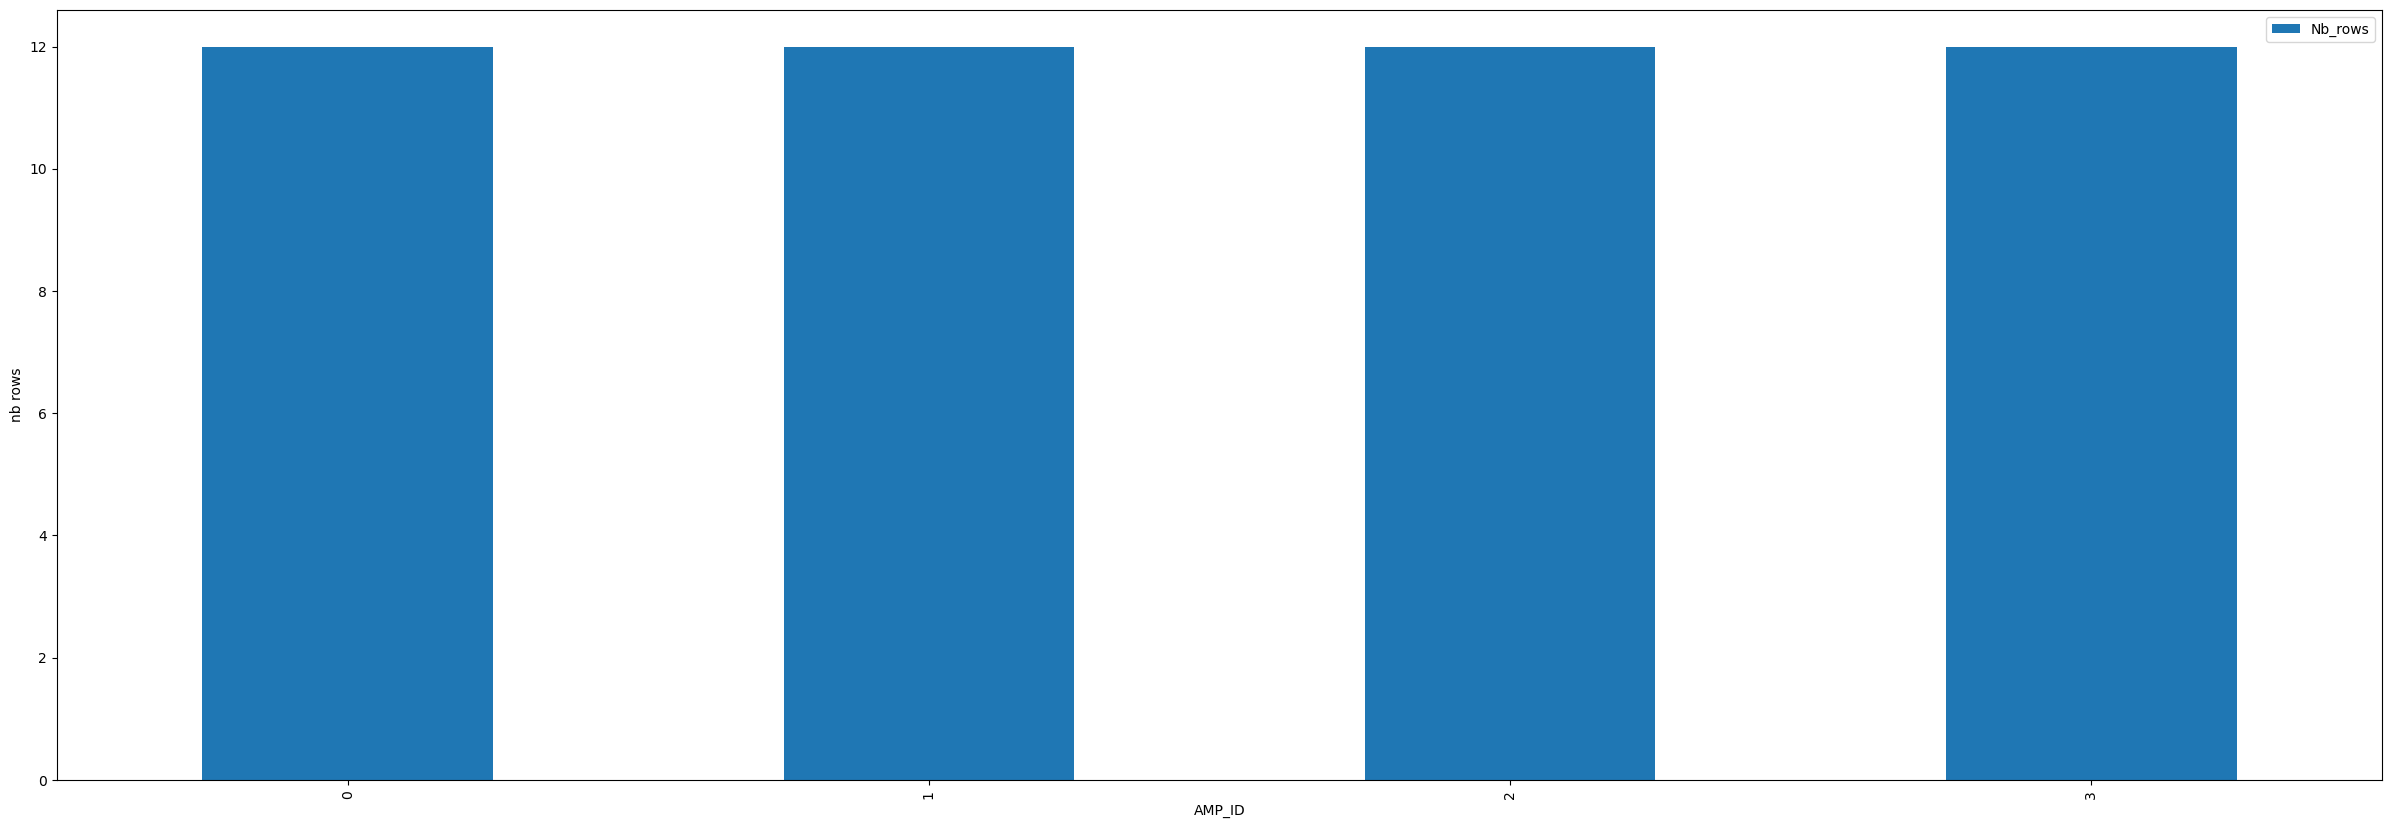

In [11]:
from tdstone2.data_distribution import PlotDistribution
PlotDistribution(Param['database'], 'questions_large', partition = 'Problem_Type')

In [12]:
tdml.remove_context()

True